# Plot spindle current versus temperature

We want to visualize the relationship between the current and the temperature of the spindle. In order to do that, we want to take averages by given time slots. 

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.optimize import minimize

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

current_folder = os.getcwd()
print(current_folder)

from parse.loadCsvSignal import loadCsvSignal
from temperatureCorrection.showTempCorrectionPlots import showTempCorrectionPlots
from utils.detectConstantSegments import detectConstantSegments
from utils import computeSlotsAverage
from temperatureCorrection.getTemperatureCorrectionData import getTemperatureCorrectionData

/Users/opatiny/git/opatiny/predictiveMaintenance/src/notebooks


## Load some data

   

In [ ]:
folderPath = "../../data/Mecatis/05_02_25/"

temperature = "lrSigSpindleTemp.csv"
currentSlots = "stSigAxCurrentS.csv"

tempPath = current_folder + "/" + folderPath + temperature
currentPath = current_folder + "/" + folderPath + currentSlots


temperatureData = loadCsvSignal(tempPath, normalize=True, debug=True)
currentData = loadCsvSignal(currentPath, normalize=True, debug=True)


getFormattedSignalData - Number of points to sort:  4272
removeDuplicates - Number duplicates: 1038
getFormattedSignalData - Number of points to sort:  2065466
removeDuplicates - Number duplicates: 0


### Plot the data

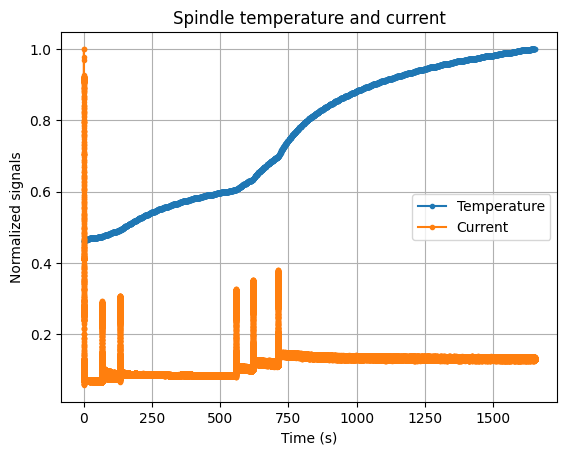

In [5]:
plt.plot(
    temperatureData.loc[:, "timeSeconds"], temperatureData.loc[:, "value"], "o-", markersize=3)
plt.plot(
    currentData.loc[:, "timeSeconds"], currentData.loc[:, "value"], "o-", markersize=3)
plt.xlabel("Time (s)")
# plt.ylabel("Temperature (°C) / Current (A)")
plt.ylabel("Normalized signals")
plt.legend(["Temperature", "Current"])

plt.title("Spindle temperature and current")
plt.grid()

plt.show()

### Plot the data averaged by slots

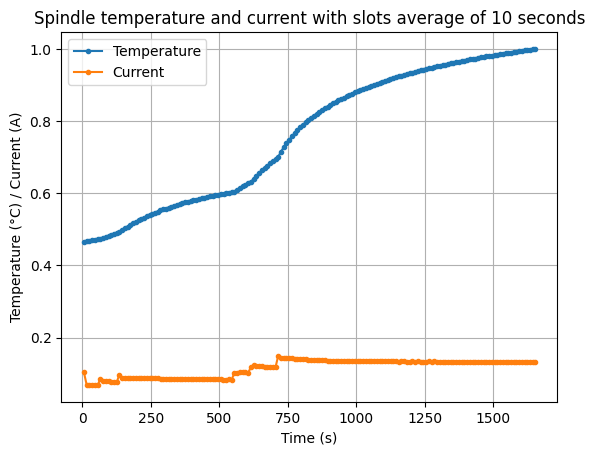

In [7]:
# apply the function to the temperature and current data
dt = 10 # seconds

temperatureSlots = computeSlotsAverage(temperatureData, dt)
currentSlots = computeSlotsAverage(currentData, dt)

# plot data versus time
plt.plot(
    temperatureSlots.loc[:, "timeSeconds"], temperatureSlots.loc[:, "value"], "o-", markersize=3)

plt.plot(
    currentSlots.loc[:, "timeSeconds"], currentSlots.loc[:, "value"], "o-", markersize=3)
plt.xlabel("Time (s)")
plt.ylabel("Temperature (°C) / Current (A)")
plt.legend(["Temperature", "Current"])
plt.title("Spindle temperature and current with slots average of " + str(dt) + " seconds")
plt.grid()
plt.show()

### Plot the current versus temperature

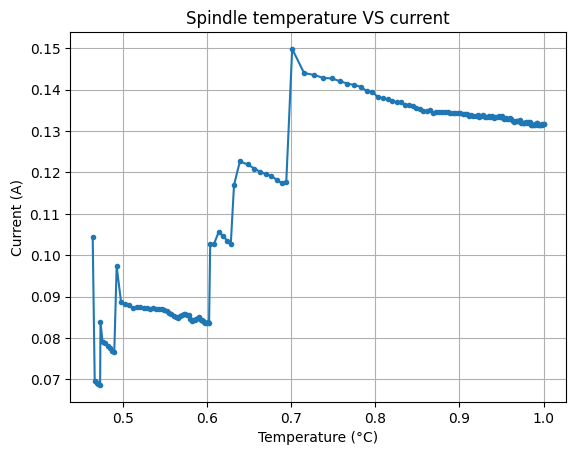

In [8]:
plt.plot(
    temperatureSlots.loc[:, "value"], currentSlots.loc[:, "value"], "-o", markersize=3)
plt.xlabel("Temperature (°C)")
plt.ylabel("Current (A)")
plt.title("Spindle temperature VS current")
plt.grid()
plt.show()

## Test `getCurrentAndTemp` on various samples

We want to plot the current VS temperature plot for multiple samples.

In [ ]:
dataPath: Path = "../../data/normalized-2025_04_08/"

samples: list[Path] = ["Mecatis_05_02_25.parquet", "Mecatis_17_02_25.parquet", "Mecatis_10_03_25.parquet"] 

data = []
for sample in samples:
    path = os.path.join(dataPath, sample)
    data.append(getTemperatureCorrectionData(path))

showTempCorrectionPlots(data, samples)

/Users/opatiny/git/opatiny/predictiveMaintenance/src/utils/computeSlotsAverage.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signal["slot"] = signal["timeSeconds"] // dt
/Users/opatiny/git/opatiny/predictiveMaintenance/src/utils/computeSlotsAverage.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signal["slot"] = signal["timeSeconds"] // dt


KeyError: 'value'

## Finding optimal temperature offset 

We want to minimize the distance between a temperature signal and a reference using just an offset.

In [ ]:


def fun(x: float, data: pd.Series, reference: pd.Series) -> float:
    error = ((data - x - reference)**2).sum()/len(data) # mean square error (MSE)
    return error

def findTemperatureOffset(temperature: pd.Series, reference: pd.Series) -> float:
    """
    Find the temperature offset that minimizes the error between the temperature and reference.

    Parameters
    ----------
    temperature (pd.Series): The temperature data.
    reference (pd.Series): The reference data.

    Returns
    -------
    float: The temperature offset.
    """
    x0 = 0.0 # start with an offset of 0°C
    result = minimize(fun, x0, args=(temperature, reference))
    return result.x[0], np.sqrt(result.fun) # return the offset and the rmse

Test the function on some data:

In [25]:
offset1, error1 = findTemperatureOffset(data[1]["temperature"], data[0]["temperature"])

print("sample 1: ", samples[1])
print("Offset: ", offset1.round(2), "°C")
print("RMSE: ", error1.round(2), "°C")

offset2, error2 = findTemperatureOffset(data[2]["temperature"], data[0]["temperature"])
print("sample 2: ", samples[2])
print("Offset: ", offset2.round(2), "°C")
print("RMSE: ", error2.round(2), "°C")


sample 1:  17_02_25
Offset:  6.35 °C
RMSE:  1.47 °C
sample 2:  10_03_25
Offset:  0.04 °C
RMSE:  0.14 °C


Plot the corrected data

In [ ]:
data[1]["temperature"] = data[1]["temperature"] - offset1
samples[1] = samples[1] + " (offset: " + str(offset1.round(2)) + "°C)"

data[2]["temperature"] = data[2]["temperature"] - offset2
samples[2] = samples[2] + " (offset: " + str(offset2.round(2)) + "°C)"

showTempCorrectionPlots(data, samples)

KeyError: 1

## Check if segments are the same in all samples

In [ ]:

dataPath: Path = "../../data/normalized-2025_04_08/"

def getSampleSegmentIndices(samplePath: Path) -> list:
    """
    Get the sample segment indices.

    Parameters
    ----------
    samplePath (str): The path to the sample.

    Returns
    -------
    list: Indices of the sample segments.
    """
    data = pd.read_parquet(samplePath)
    time = data["timeSeconds"]
    command = data["stSigSpindleVelocity"]
    return detectConstantSegments(time, command)

indices1 = getSampleSegmentIndices(os.path.join(dataPath, "Mecatis_05_02_25.parquet"))
print("Indices 1: ", indices1)
indices2 = getSampleSegmentIndices(os.path.join(dataPath, "Mecatis_17_02_25.parquet"))
print("Indices 2: ", indices2)
indices3 = getSampleSegmentIndices(os.path.join(dataPath, "Mecatis_10_03_25.parquet"))
print("Indices 3: ", indices3)


Indices 1:  [(893, 84083), (84959, 165527), (166403, 694810), (695686, 772705), (773581, 889295), (890171, 2065465)]
Indices 2:  [(893, 84072), (84948, 165512), (166388, 694795), (695670, 772677), (773552, 889265), (890141, 2065435)]
Indices 3:  [(892, 84083), (84958, 165521), (166396, 694796), (695672, 772690), (773566, 889276), (890151, 2065449)]


Remarks:
- different samples have different segment indices
- samples contains different numcer of points

## Split spindle current into segments
We want to split all the spindle current into segments and process each of the segments independently. First we need to find the start and end indices of the segments.

First, load a sample and put useful signals into some variables.

In [ ]:
dataPath: Path = "../../data/normalized-2025_04_08/"
samplePath = os.path.join(dataPath, "Mecatis_05_02_25.parquet")

data = pd.read_parquet(samplePath)
time = data["timeSeconds"]
command = data["stSigSpindleVelocity"]
segmentIndices = detectConstantSegments(time, command)

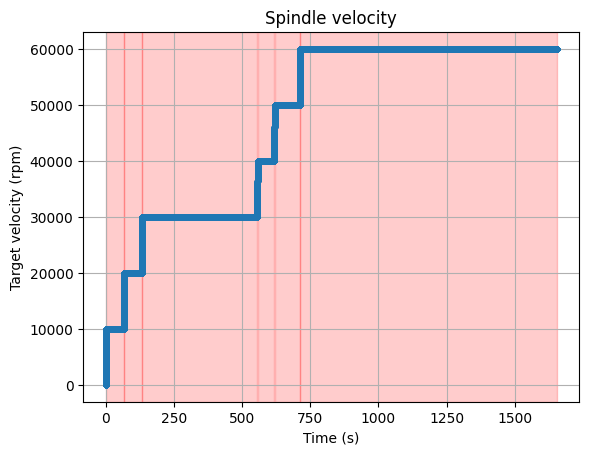

In [ ]:
# plot the data
plt.figure()
plt.plot(time, command, "o-", markersize=3)
plt.xlabel("Time (s)")
plt.ylabel("Target velocity (rpm)")
plt.title("Spindle velocity")
plt.grid()
for segment in segmentIndices:
    plt.axvspan(time[segment[0]], time[segment[1]], color="red", alpha=0.2)
plt.show()

## Cut a signal into the segments and plot all the segments versus time

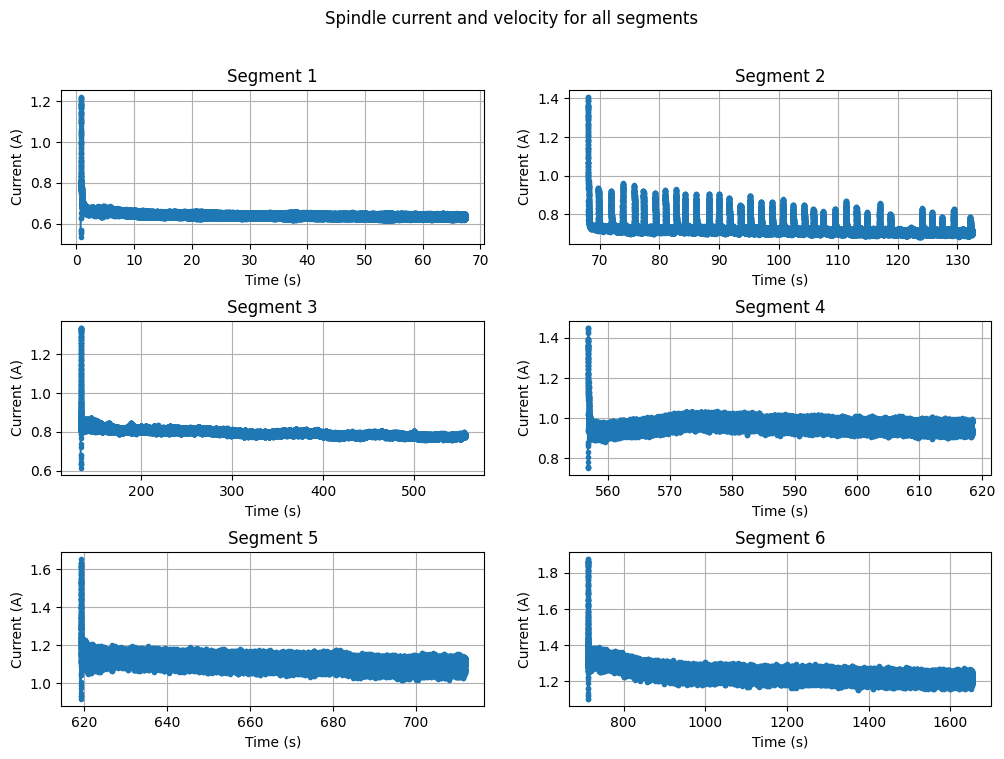

In [ ]:
spindleCurrent = data["stSigAxCurrentS"]
segmentIndices = indices1

# plot all the data using suplots

nbColumns = 2
nbRows = 3

fig, axs = plt.subplots(nbRows, nbColumns, figsize=(12, 8))
fig.subplots_adjust(hspace=0.5)
fig.suptitle("Spindle current and velocity for all segments")

# plot each segment
for i in range(len(segmentIndices)):
    segment = segmentIndices[i]
    start = segment[0]
    end = segment[1]
    
    segmentTime = time[start:end]
    segmentCurrent = spindleCurrent[start:end]

    colIndex = i % nbColumns
    rowIndex = i // nbColumns

    axs[rowIndex, colIndex].plot(segmentTime, segmentCurrent, "o-", markersize=3)
    axs[rowIndex, colIndex].set_xlabel("Time (s)")
    axs[rowIndex, colIndex].set_ylabel("Current (A)")
    axs[rowIndex, colIndex].set_title("Segment " + str(i+1))
    axs[rowIndex, colIndex].grid()

plt.show()